In [39]:
import tensorflow as tf
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal

In [40]:
def load_model_and_data(model_path, record_path):
    if not tf.io.gfile.exists(model_path):
        raise FileNotFoundError(f"Model file {model_path} not found.")
    if not tf.io.gfile.exists(record_path + '.dat'):
        raise FileNotFoundError(f"Record file {record_path} not found.")
    
    model = tf.keras.models.load_model(model_path)
    record = wfdb.rdrecord(record_path)
    return model, record

In [41]:
def resample_signal(original_signal, original_fs, target_fs=100):
    #The model was trained on ECG signals sampled at 100 Hz
    
    if original_fs == target_fs:
        return original_signal
    gcd = np.gcd(int(original_fs), int(target_fs))
    up = target_fs // gcd
    down = original_fs // gcd
    return signal.resample_poly(original_signal, up, down, axis=0)

In [42]:
def adjust_signal_length(signal, target_length):
    current_length = signal.shape[0]
    if current_length < target_length:
        return np.pad(signal, ((0, target_length - current_length), (0, 0)), mode='constant')
    return signal[:target_length, :]

In [43]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv1D):
            return layer.name
    raise ValueError("No convolutional layer found in the model.")

In [44]:
def compute_grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        class_output = preds[:, class_idx]
    
    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    
    conv_output = conv_outputs[0].numpy()
    conv_output *= pooled_grads.numpy()
    
    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-8)
    
    return heatmap, class_idx.numpy()

In [62]:
def plot_ecg_with_gradcam(signal, heatmap, lead_names, fs, sample_idx, class_idx):

    num_leads = signal.shape[1]
    time = np.arange(signal.shape[0]) / fs

    # Create a figure with subplots for each lead
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(num_leads, 1, figure=fig)

    # Normalize the heatmap for overlay
    heatmap_normalized = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-8)

    # Plot individual leads with heatmap overlay
    for lead in range(num_leads):
        ax = fig.add_subplot(gs[lead, 0])

        # Increase vertical offset for clarity
        vertical_offset = lead * 3  # Increased from 1.2 to 3

        # Plot the ECG signal for the current lead
        ax.plot(time, signal[:, lead] + vertical_offset, linewidth=1, color='black')

        # Overlay the heatmap on the current lead
        heatmap_extent = [time[0], time[-1], vertical_offset - 1.5, vertical_offset + 1.5]  # Adjust y-axis range
        ax.imshow(
            np.expand_dims(heatmap_normalized, axis=0),
            cmap='viridis',
            aspect='auto',
            extent=heatmap_extent,
            alpha=0.4,  # Adjust transparency
            origin='lower'
        )

        # Add labels and formatting
        ax.set_ylabel(lead_names[lead], rotation=0, ha='right', va='center')
        ax.set_yticks([])
        ax.set_ylim(vertical_offset - 2, vertical_offset + 2)  # Expanded y-axis limits
        if lead != num_leads - 1:
            ax.set_xticks([])

    # Add title and labels
    plt.suptitle(f"ECG Sample #{sample_idx} - Predicted Class: {class_idx}\nGrad-CAM Heatmap Overlay", y=0.92)
    plt.xlabel("Time (seconds)")

    # Tight layout for better spacing
    plt.tight_layout()
    plt.show()

In [63]:
# Configuration
MODEL_PATH = "model.keras.h5"
RECORD_PATH = "./input/14"
REQUIRED_LENGTH = 1000
NUM_SAMPLES_TO_PLOT = 1
TARGET_FS = 100

Processing segment 1/1


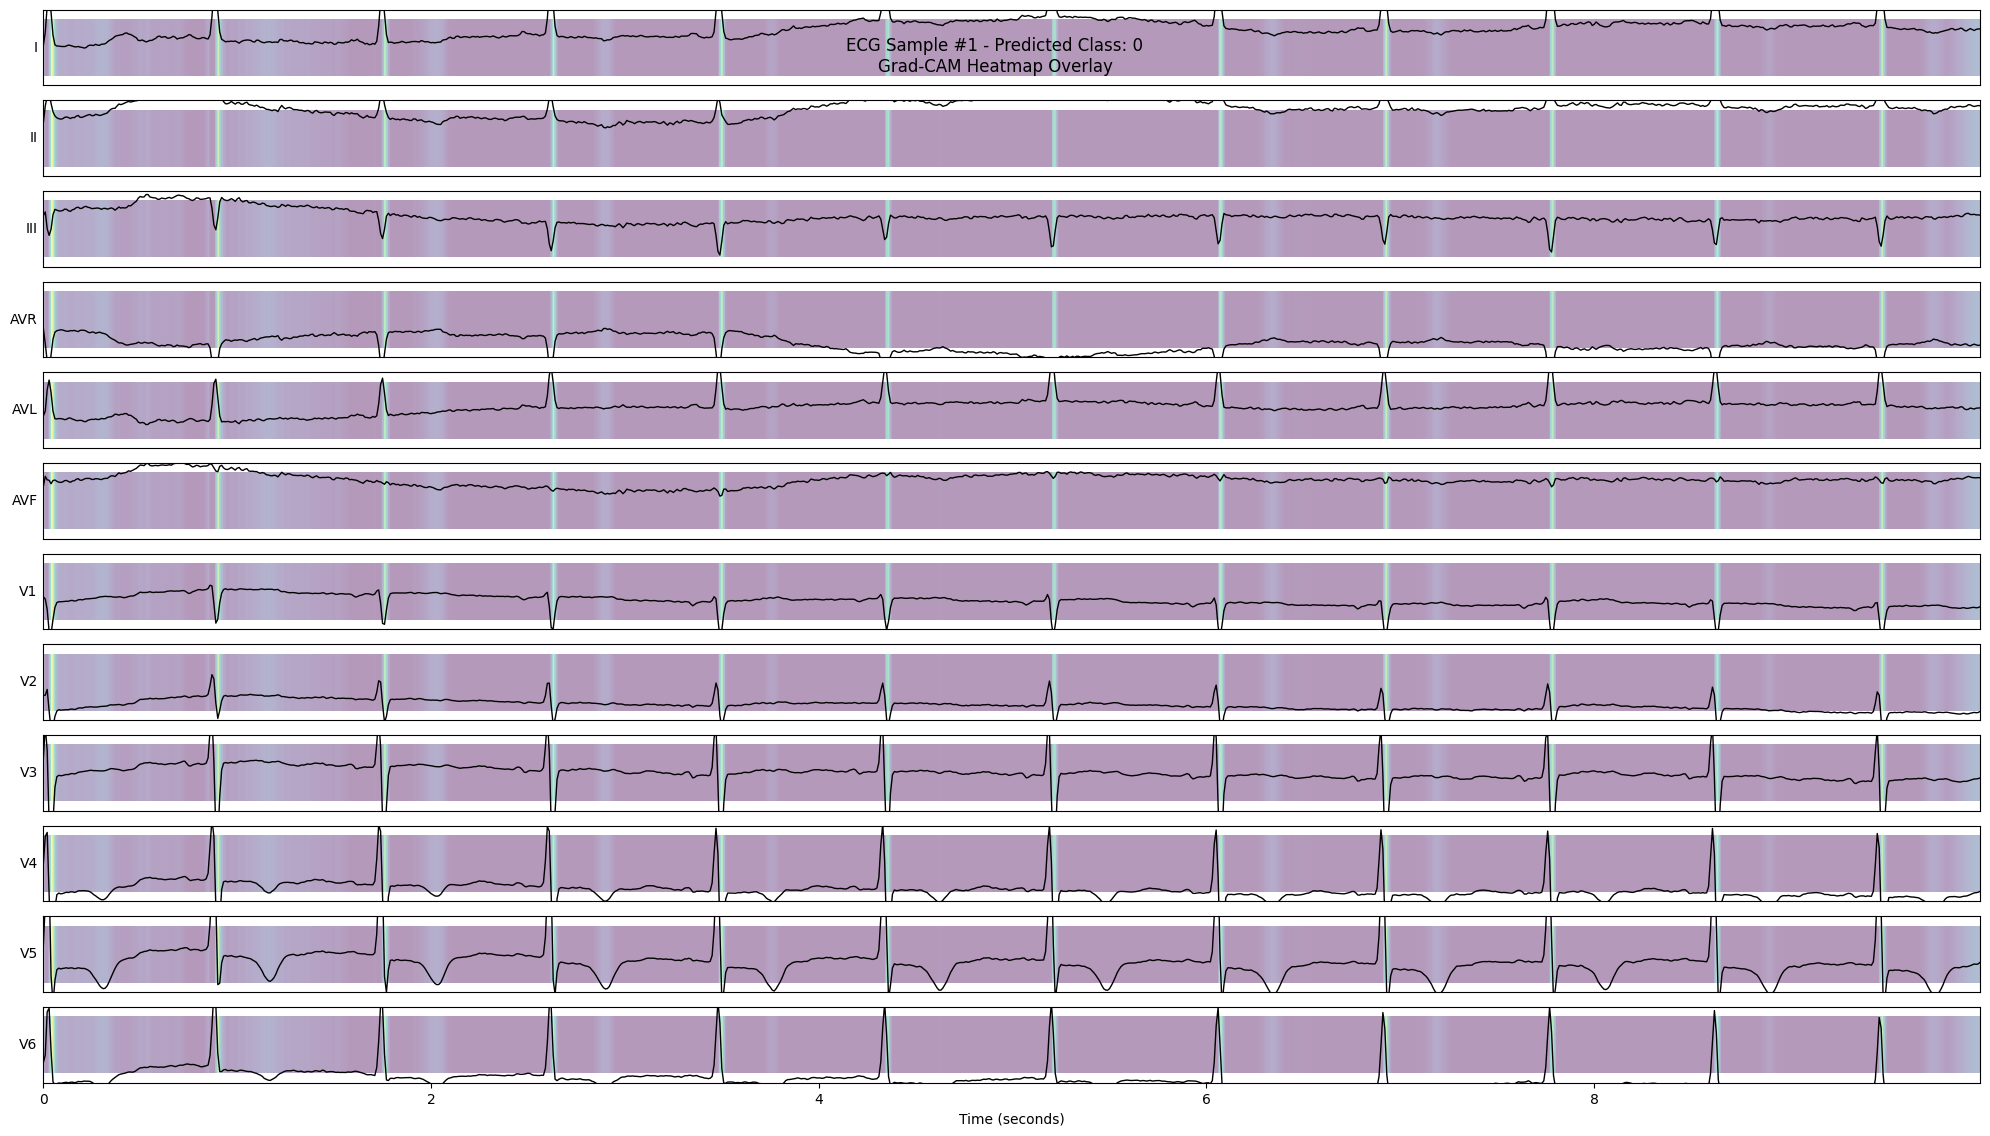

In [64]:
try:
    # Load model and data
    model, record = load_model_and_data(MODEL_PATH, RECORD_PATH)
    conv_layer_name = find_last_conv_layer(model)
    
    # Validate ECG signal dimensions
    original_signal = record.p_signal
    original_fs = record.fs
    if original_signal.ndim != 2 or original_signal.shape[1] != 12:
        raise ValueError("ECG signal must have shape (samples, 12 leads).")
    
    # Resample and process signal
    resampled_signal = resample_signal(original_signal, original_fs, TARGET_FS)
    total_samples = resampled_signal.shape[0]
    num_segments = min(NUM_SAMPLES_TO_PLOT, total_samples // REQUIRED_LENGTH)
    
    for i in range(num_segments):
        print(f"Processing segment {i+1}/{num_segments}")
        start_idx = i * REQUIRED_LENGTH
        end_idx = start_idx + REQUIRED_LENGTH
        
        segment = resampled_signal[start_idx:end_idx, :]
        adjusted_signal = adjust_signal_length(segment, REQUIRED_LENGTH)
        
        input_tensor = tf.convert_to_tensor(
            np.expand_dims(adjusted_signal, 0), dtype=tf.float32
        )
        
        # Validate input shape
        if input_tensor.shape[1:] != model.input_shape[1:]:
            raise ValueError(f"Input shape {input_tensor.shape} doesn't match model's expected shape {model.input_shape}.")
        
        # Compute Grad-CAM and plot
        heatmap, class_idx = compute_grad_cam(model, input_tensor, conv_layer_name)
        plot_ecg_with_gradcam(
            adjusted_signal,
            heatmap,
            record.sig_name,
            TARGET_FS,
            sample_idx=i+1,
            class_idx=class_idx
        )
        
except Exception as main_error:
    print(f"Critical error: {str(main_error)}")